In [11]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import numpy as np
import torch
import torch.nn.functional as F

make_normal = -torch.Tensor([
    [0, -1, 0, 1],
    [1, 0, -1, 0]
]).T

target = torch.rand(41, 41) * 0.2
for d in range(10):
    target[10:20-d, 10+d] = 1 - target[10:20-d, 10+d]
    target[20+d:30, 30-d] = 1 - target[20+d:30, 30-d]
target[:10,:] = 1 - target[:10,:]
target[25:,:] = 1 - target[25:,:]

In [12]:
def prntshape(tensor):
    t = globals()[tensor]
    print(tensor, tuple(t.shape))

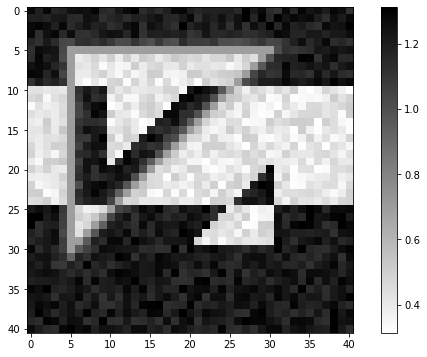

In [4]:
def compute_loss(triangle, target):
    edges = torch.stack([triangle[:4], triangle[2:], torch.cat([triangle[4:], triangle[:2]])], dim=0)

    normals = torch.matmul(edges, make_normal)
    normals = normals / torch.pow(normals, 2).sum(dim=1, keepdims=True).sqrt()
    dists   = torch.sum(edges[:,:2] * normals, dim=1)

    ls = torch.arange(0, 41).float()
    grid = torch.stack(torch.meshgrid(ls, ls), dim=-1)

    bc_grid = grid.view(-1, 2).unsqueeze(0)
    bc_normals = normals.unsqueeze(2)
    bc_dists = dists.unsqueeze(1)
    
    sdf = torch.matmul(bc_grid, bc_normals).squeeze(2) - bc_dists
    sdf = sdf.view(3, *target.shape)
    sdf = torch.min(sdf, dim=0)[0]
    sdf = torch.tanh(sdf)
    # sdf = sdf * torch.exp(-sdf * sdf / 30)
    # sdf = torch.sign(sdf) - torch.tanh(sdf)

    outsideness = F.logsigmoid(-sdf)
    insideness = F.logsigmoid(sdf)
    loss = -insideness * target - outsideness * (1 - target)
    
    return loss.mean(), loss

#                    x1 y1 x2 y2
triangle = torch.Tensor([5, 5, 30, 5, 5, 30])
triangle.requires_grad = True

_loss, _loss_surf = compute_loss(triangle, target)
# print(_insideness.min().item(), _insideness.max().item())
plt.imshow(_loss_surf.detach(), cmap='gray_r')
plt.colorbar()

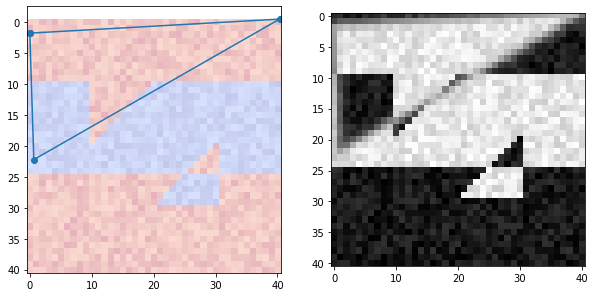

In [83]:
#                    x1 y1 x2 y2
triangle = torch.Tensor([0, 0, 20, 0, 0, 40]) + torch.randn(6)
triangle.requires_grad = True
opt = torch.optim.Adam([triangle], 5e-2)

# initialization function: plot the background of each frame
fig, (ax1, ax2) = plt.subplots(1, 2)

_loss, _loss_surf = compute_loss(triangle, target)
trgt = ax1.imshow(target.detach(), cmap='coolwarm', alpha=0.3)
ins = ax2.imshow(_loss_surf.detach(), cmap='gray_r')
t = triangle.detach()
line, = ax1.plot([t[1], t[3], t[5], t[1]], [t[0], t[2], t[4], t[0]], 'o-')

def init():
    t = triangle.detach()
    line.set_data(
        [t[1], t[3], t[5], t[1]],
        [t[0], t[2], t[4], t[0]],
    )
    return (line, ins, )

def animate(i):
    for _ in range(2):
        opt.zero_grad()
        loss, _loss_surf = compute_loss(triangle, target)
        loss.backward()
        opt.step()
    t = triangle.detach()
    line.set_data(
        [t[1], t[3], t[5], t[1]],
        [t[0], t[2], t[4], t[0]],
    )
    ins.set_data(_loss_surf.detach())
    
    return (line, ins, )

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)

In [84]:
HTML(anim.to_html5_video())

In [27]:
make_normal = -torch.Tensor([
    [0, -1, 0, 1],
    [1, 0, -1, 0]
]).T

target = torch.rand(41, 41) * 0.2
for d in range(10):
    target[10:20-d, 10+d] = 1 - target[10:20-d, 10+d]
    target[20+d:30, 30-d] = 1 - target[20+d:30, 30-d]
target[:10,:] = 1 - target[:10,:]
target[25:,:] = 1 - target[25:,:]

def edge_loss(edges, target):
    normals = torch.matmul(edges, make_normal)
    normals = normals / torch.pow(normals, 2).sum(dim=1, keepdims=True).sqrt()
    dists   = torch.sum(edges[:,:2] * normals, dim=1)

    ls = torch.arange(0, 41).float()
    grid = torch.stack(torch.meshgrid(ls, ls), dim=-1)

    bc_grid = grid.view(-1, 2).unsqueeze(0)
    bc_normals = normals.unsqueeze(2)
    bc_dists = dists.unsqueeze(1)
    
    sdf = torch.matmul(bc_grid, bc_normals).squeeze(2) - bc_dists
    sdf = sdf.view(3, *target.shape)
    sdf = torch.min(sdf, dim=0)[0]
    sdf = torch.tanh(sdf)

    outsideness = F.logsigmoid(-sdf)
    insideness = F.logsigmoid(sdf)
    loss = -insideness * target - outsideness * (1 - target)
    
    return loss.mean(), loss

torch.Size([1, 4])


RuntimeError: shape '[3, 41, 41]' is invalid for input of size 1681

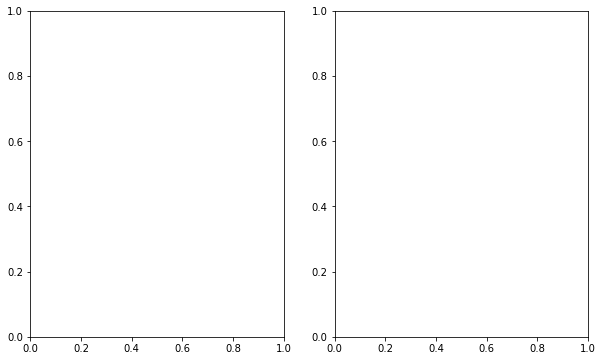

In [28]:
#                    x1 y1 x2 y2
edges = torch.Tensor([[0, 0, 20, 30]])
edges.requires_grad = True
opt = torch.optim.Adam([triangle], 5e-2)

# initialization function: plot the background of each frame
fig, (ax1, ax2) = plt.subplots(1, 2)

_loss, _loss_surf = edge_loss(edges, target)
trgt = ax1.imshow(target.detach(), cmap='coolwarm', alpha=0.3)
ins = ax2.imshow(_loss_surf.detach(), cmap='gray_r')
t = edges[0].detach()
line, = ax1.plot([t[1], t[3]], [t[0], t[2]], 'o-')

def init():
    t = edges[0].detach()
    line.set_data(
        [t[1], t[3]],
        [t[0], t[2]],
    )
    return (line, ins, )

def animate(i):
    for _ in range(2):
        opt.zero_grad()
        loss, _loss_surf = edge_loss(edges, target)
        loss.backward()
        opt.step()
    t = edges[0].detach()
    line.set_data(
        [t[1], t[3]],
        [t[0], t[2]],
    )
    ins.set_data(_loss_surf.detach())
    
    return (line, ins, )

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=200, interval=20, blit=True)